In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from IPython.display import HTML
from pathlib import Path
from PIL import Image
from pytorch_msssim import SSIM

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

# This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

Random Seed:  999


In [3]:
pathsdf = pd.read_feather("input_and_inchi_imgs_paths.feather")

BATCH_SIZE = 32
INP_SIZE = (256, 256)
N_INP_CH = 1
N_OUT_CH = 3
LR = 1e-2
EPOCHS = 10
beta1 = 0.5

# Data

In [55]:
from PIL import ImageFilter
class ReconsDataset(Dataset):
    def __init__(self, pathsdf, tsfmsX, tsfmsY):
        super().__init__()
        self.pathsdf = pathsdf
        self.tsfmsX = tsfmsX
        self.tsfmsY = tsfmsY
    
    def __len__(self):
        return len(self.pathsdf)
    
    def __getitem__(self, idx):
        inp_imgpath, inchi_imgpath = self.pathsdf.iloc[idx,:]
        inp_img = Image.open(inp_imgpath)
        inchi_img = Image.open(inchi_imgpath)
#         inchi_img = inchi_img.filter(ImageFilter.MaxFilter(3))
        
        inp_img = self.tsfmsX(inp_img)
        inchi_img = self.tsfmsY(inchi_img)
        return inp_img, inchi_img

In [102]:
tsfmsX = transforms.Compose([
    transforms.ToTensor(),
#     transforms.RandomErasing(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])
tsfmsY = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

dataset = ReconsDataset(pathsdf, tsfmsX=tsfmsX, tsfmsY=tsfmsX)
train_ds, val_ds = random_split(dataset, [8000, 2000])
print(f"# samples in trainset = {len(train_ds)} and valset = {len(val_ds)}")

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=4)

# samples in trainset = 8000 and valset = 2000


<ipython-input-103-0b187bd46257>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(121)
<ipython-input-103-0b187bd46257>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(122)


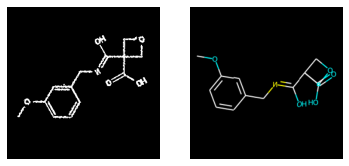

In [103]:
inpX, inchiX = next(iter(train_dl))
for i in range(BATCH_SIZE):
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(inpX[i].squeeze(0), cmap='gray')
    ax2.imshow(inchiX[i].permute(1,2,0))
    ax1.axis('off')
    ax2.axis('off')

# Model

In [52]:
import pytorch_lightning as pl
import torch.nn.functional as F

In [137]:
# class ResEncBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, k=3, s=2):
#         super().__init__()
#         if in_channels == out_channels:
#             k = 1
#         self.skip = nn.Conv2d(in_channels, out_channels, k, s, k//2, bias=False)
#         self.seq = nn.Sequential(
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU(True),
#             nn.Conv2d(in_channels, out_channels, k, s, k//2, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels, out_channels, k, 1, k//2, bias=False)
#         )
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         skip = self.skip(x)        
#         out = self.seq(x)
#         out = out + skip
#         out = self.relu(out)
#         return out

class ResEncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, s=2):
        super().__init__()
        if in_channels == out_channels:
            k = 1
        self.skip = nn.Conv2d(in_channels, out_channels, k, s, k//2, bias=False)
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, k, s, k//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, k, 1, k//2, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        skip = self.skip(x)        
        out = self.seq(x)
        out = out + skip
        out = self.relu(out)
        return out
    
class ResDecBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=4, s=2, p=1):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, k, s, p, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.seq(x)
        return out
    
class ResUNet(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=3, lr=1e-1):
        super().__init__()
        self.d1 = ResEncBlock(in_channels, 64) # 128
        self.d2 = ResEncBlock(64, 128) # 64
        self.d3 = ResEncBlock(128, 256) # 32
        self.d4 = ResEncBlock(256, 256) # 16
        
        self.u4 = ResDecBlock(256, 256) # 32
        self.u3 = ResDecBlock(256, 128) # 64
        self.u2 = ResDecBlock(128, 64) # 128
        self.u1 = ResDecBlock(64, out_channels) # 256
        
        self.relu = nn.ReLU()
        
        self.ssim_module = SSIM(data_range=255, size_average=True, channel=out_channels)
        self.cos_loss = nn.CosineSimilarity()
        
        self.lr = lr
            
    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        
        u4 = self.u4(d4) + d3
        u4 = self.relu(u4)
        u3 = self.u3(u4) + d2
        u3 = self.relu(u3)
        u2 = self.u2(u3)
        u1 = self.u1(u2)
        u1 = torch.sigmoid(u1)
        return u1
    
    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch
        Yhat = self.forward(X)
#         loss = 1 - self.cos_loss(Yhat.view(X.shape[0], -1), Y.view(X.shape[0], -1)).mean()
#         ssim_loss = 1 - self.ssim_module(Y, Yhat)
        loss = F.mse_loss(Yhat, Y)
#         self.log_dict({'train_ssim_loss': ssim_loss, 'train_mse_loss': loss}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, Y = val_batch
        Yhat = self.forward(X)
#         loss = 1 - self.cos_loss(Yhat.view(X.shape[0], -1), Y.view(X.shape[0], -1)).mean()
#         ssim_loss = 1 - self.ssim_module(Y, Yhat)
        loss = F.mse_loss(Yhat, Y)
#         self.log('valid_acc', self.ssim_module(Y, Yhat), on_step=True, on_epoch=True)
#         self.log_dict({'val_ssim_loss': ssim_loss, 'val_mse_loss': loss}, on_step=False, on_epoch=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5000),
            'name': 'expo_lr'
        }
        return [optimizer], [lr_scheduler]
    
net = ResUNet()

In [138]:
# training
trainer = pl.Trainer(gpus=1, num_processes=6, auto_lr_find=True, max_epochs=1, default_root_dir="chkpts")
trainer.fit(net, train_dl, val_dl)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type             | Params
--------------------------------------------------
0  | d1          | ResEncBlock      | 38.3 K
1  | d2          | ResEncBlock      | 295 K 
2  | d3          | ResEncBlock      | 1.2 M 
3  | d4          | ResEncBlock      | 197 K 
4  | u4          | ResDecBlock      | 1.0 M 
5  | u3          | ResDecBlock      | 524 K 
6  | u2          | ResDecBlock      | 131 K 
7  | u1          | ResDecBlock      | 3.1 K 
8  | relu        | ReLU             | 0     
9  | ssim_module | SSIM             | 0     
10 | cos_loss    | CosineSimilarity | 0     
--------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.680    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [139]:
# trainer.model

In [140]:
out = net(inpX)

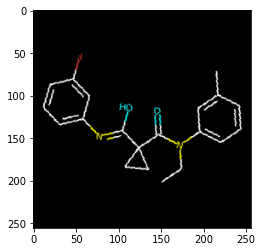

In [141]:
plt.imshow(inchiX[0].permute(1,2,0).detach())

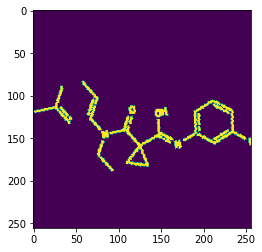

In [142]:
plt.imshow(inpX[0].permute(1,2,0).detach())

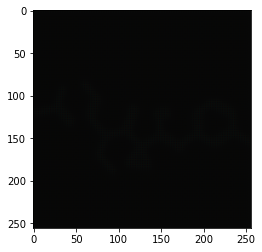

In [143]:
plt.imshow(out[0].permute(1,2,0).detach())

In [144]:
cos = nn.CosineSimilarity()
output = cos(inchiX.float().view(out.shape[0], -1), out.float().view(out.shape[0], -1))

In [145]:
output

tensor([0.1966, 0.1475, 0.1729, 0.1854, 0.1469, 0.1577, 0.1390, 0.1676, 0.1718,
        0.1589, 0.1491, 0.1482, 0.1893, 0.1727, 0.1657, 0.1530, 0.1454, 0.1356,
        0.1765, 0.1461, 0.1614, 0.1865, 0.1493, 0.1594, 0.2011, 0.2028, 0.1735,
        0.1940, 0.1582, 0.1803, 0.1819, 0.1630], grad_fn=<DivBackward0>)

In [146]:
output.mean()

tensor(0.1668, grad_fn=<MeanBackward0>)

## It fails to reconstruct a good image because the structure from input image to inchi image changes drastically. Usually reconstruction is based on refining or improving the same structure the input image has. Therefore, simple encoder-decorder cannot do the job. Either the network needs to be more deep to shift the pixels or some transformation is required.